# Classification of the CIFAR dataset using Keras3 and PyTorch

Contrary to the MNIST dataset, CIFAR10 is a dataset of colour images of objects. Here I train a CNN to predict the class of an image, using Keras3 with PyTorch as the backend.

In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'torch'

import keras

import numpy as np
import matplotlib.pyplot as plt
import sys,os
from importlib import reload
import pandas as pd
import seaborn as sns

In [2]:
fit_verbosity = 1 # Verbosity during training : 0 = silent, 1 = progress bar, 2 = one line per epoch

## Prepare data

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Normalise the data

In [4]:
print('Before normalization : Min={}, max={}'.format(x_train.min(),x_train.max()))

xmax=x_train.max()
x_train = x_train / xmax
x_test  = x_test  / xmax

print('After normalization  : Min={}, max={}'.format(x_train.min(),x_train.max()))

Before normalization : Min=0, max=255
After normalization  : Min=0.0, max=1.0


Visualise a few examples

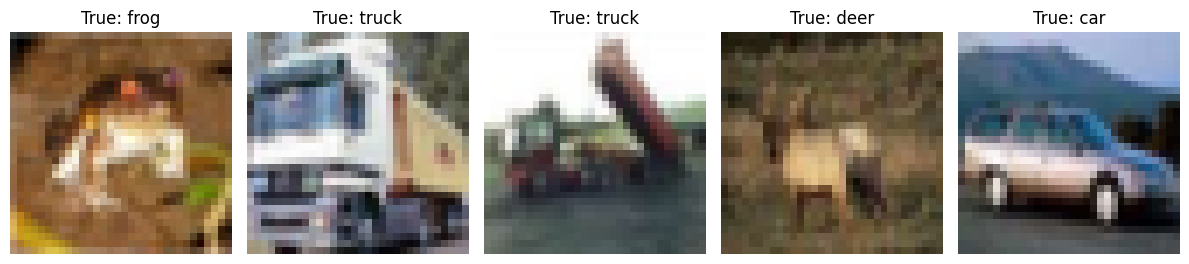

In [5]:
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    axes[i].imshow(x_train[i].squeeze())
    axes[i].set_title(f'True: {classes[y_train[i].item()]}')
    axes[i].axis('off')
plt.tight_layout()

## Define the model

In [6]:
model = keras.models.Sequential()

model.add(keras.layers.Input((32,32,3)))

model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Flatten()) 
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Note: to use categorical_crossentropy instead, we need to convert labels:
# y_train_onehot = keras.utils.to_categorical(y_train, num_classes=10)
# y_test_onehot = keras.utils.to_categorical(y_test, num_classes=10)

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,202 (625.79 KB)

 Trainable params: 160,202 (625.79 KB)

 Non-trainable params: 0 (0.00 B)

## Train model or load saved model and history

In [8]:
batch_size  = 512
epochs =  16

if os.path.exists('./models/cifar_model.keras'):
    model = keras.saving.load_model('./models/cifar_model.keras')
    history=np.load('./models/cifar_history.npy',allow_pickle=True).item()
else:
    history = model.fit(x_train, y_train,
                        batch_size = batch_size,
                        epochs = epochs,
                        verbose = fit_verbosity,
                        validation_data = (x_test, y_test),
                        shuffle = True)

    model.save('./models/cifar_model.keras')
    np.save('./models/cifar_history.npy', history.history)
    history = history.history

## Evaluate model

In [9]:
score = model.evaluate(x_test, y_test, verbose=0)

print(f'Test loss     : {score[0]:4.4f}')
print(f'Test accuracy : {score[1]:4.4f}')

Test loss     : 0.9090
Test accuracy : 0.6800


In [24]:
# Alternatively we can retrieve the loss and accuracy from the history

print(f"Training accuracy: \t{max(history['accuracy']):4.4f}")
print(f"Training loss: \t\t{min(history['loss']):4.4f}")
print(f"Test accuracy: \t{max(history['val_accuracy']):4.4f}")
print(f"Test loss: \t{min(history['val_loss']):4.4f}")

Training accuracy: 	0.6471
Training loss: 		1.0042
Test accuracy: 	0.6800
Test loss: 	0.9090


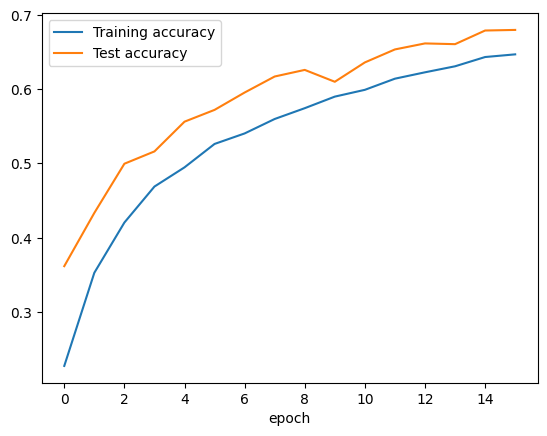

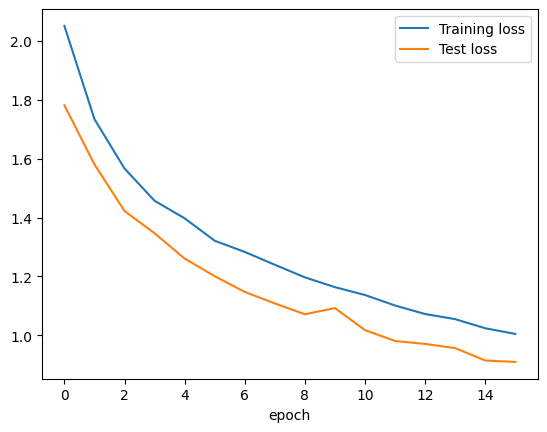

In [25]:
plt.plot(history['accuracy'], label="Training accuracy")
plt.plot(history['val_accuracy'], label="Test accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(history['loss'], label="Training loss")
plt.plot(history['val_loss'], label="Test loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
outputs = model.predict(x_test)
predictions = keras.ops.argmax(outputs, axis=1)
labels = y_test.reshape(10000,)

# count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

for label, prediction in zip(labels, predictions):
    if label == prediction:
        correct_pred[classes[label]] += 1
    total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname} is {accuracy:.1f} %')

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step
Accuracy for class: plane is 70.3 %
Accuracy for class: car is 86.5 %
Accuracy for class: bird is 53.1 %
Accuracy for class: cat is 47.7 %
Accuracy for class: deer is 60.9 %
Accuracy for class: dog is 50.4 %
Accuracy for class: frog is 86.7 %
Accuracy for class: horse is 71.6 %
Accuracy for class: ship is 84.7 %
Accuracy for class: truck is 68.1 %


Visualise some predictions and compare with the ground truth

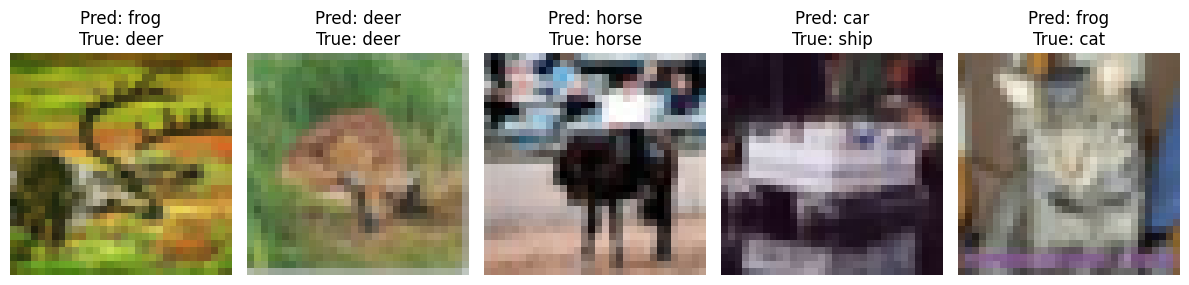

In [16]:
n = 5
subset = np.random.choice(range(len(x_test)), size=n, replace=False)

subset_images = x_test[subset]
subset_predictions = predictions[subset]
subset_labels = labels[subset]

fig, axes = plt.subplots(1, n, figsize=(12, 3))
for i in range(n):
    axes[i].imshow(subset_images[i].squeeze())
    axes[i].set_title(f'Pred: {classes[subset_predictions[i]]}\nTrue: {classes[subset_labels[i]]}')
    axes[i].axis('off')
plt.tight_layout()


Display the confusion matrix

<Axes: >

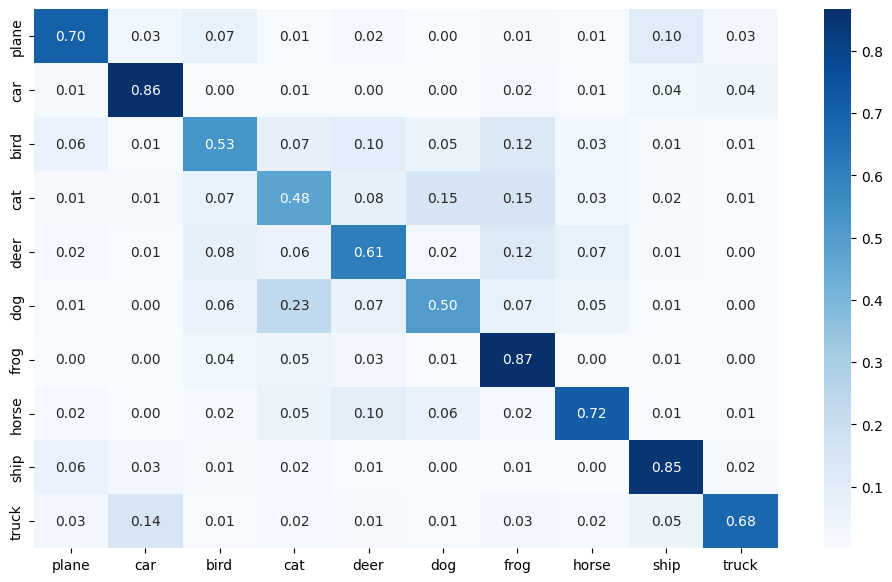

In [ ]:
cf_matrix = confusion_matrix(labels, predictions)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True, fmt = ".2f", cmap='Blues')